In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- `weeks_since_first_review`
- `num_reviews`
- `sum_review_ratings`
- `avg_review_length`
- `last_review_weeks_ago`
- `last_review_summary_text`: Embedding
- `last_reviewed_product_title`: Embedding
- `last_reviewed_product_category`
- `last_review_is_verified`
- `avg_review_rating`
- `pct_verified_reviews`
- `std_review_rating`
- `min_review_rating`
- `max_review_rating`
- `avg_reviewed_product_rating`
- `sum_reviewed_product_rating`
- `std_reviewed_product_rating`
- `min_reviewed_product_rating`
- `max_reviewed_product_rating`
- `avg_reviewed_product_price`
- `sum_reviewed_product_price`
- `std_reviewed_product_price`
- `min_reviewed_product_price`
- `max_reviewed_product_price`
- `reviewed_product_modal_category`
- `user_bias`: average over products the user reviewed of user's_review - avg_product_review / std_product review
- trend stuff: avg value in last 6 months - avg value in previous 6 month window
    - `num_reviews_trend`
    - `avg_rating_trend`
    - `avg_price_trend`
    - `avg_user_bias_trend`

In [2]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('amazon/amazon.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('amazon/user-churn/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=800_000))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [3]:
utils.validate_feature_tables('user_churn', conn)

Validating train
train labels size: 4,732,555 x 3
train feats size: 800,000 x 33
⚠️ 3,932,555 samples are missing from feats table!

Validating val
val labels size: 409,792 x 3
val feats size: 409,792 x 33

Validating test
test labels size: 351,885 x 2
test feats size: 351,885 x 32

❌ 1 errors found!


^-- Failure expected bc of subsampling

In [4]:
%%sql train_df <<
from churn_train_feats

In [5]:
infer_df_stype(train_df)

{'customer_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'churn': <stype.categorical: 'categorical'>,
 'weeks_since_first_review': <stype.numerical: 'numerical'>,
 'num_reviews': <stype.numerical: 'numerical'>,
 'sum_review_ratings': <stype.numerical: 'numerical'>,
 'avg_review_length': <stype.numerical: 'numerical'>,
 'last_review_weeks_ago': <stype.numerical: 'numerical'>,
 'last_review_summary_text': <stype.text_embedded: 'text_embedded'>,
 'last_reviewed_product_title': <stype.text_embedded: 'text_embedded'>,
 'last_reviewed_product_category': <stype.text_embedded: 'text_embedded'>,
 'last_review_is_verified': <stype.categorical: 'categorical'>,
 'avg_review_rating': <stype.numerical: 'numerical'>,
 'pct_verified_reviews': <stype.numerical: 'numerical'>,
 'std_review_rating': <stype.numerical: 'numerical'>,
 'min_review_rating': <stype.categorical: 'categorical'>,
 'max_review_rating': <stype.categorical: 'categorical'>,
 'avg_reviewed_product_

In [6]:
utils.feature_summary_df(train_df.sample(20_000), 'churn', classification=True)

,Label Corr.,Label MI,NaN %
customer_id,0.151,0.022,0.0%
min_reviewed_product_rating,0.112,0.014,82.8%
std_review_rating,-0.030,0.011,85.8%
std_reviewed_product_rating,0.030,0.009,85.8%
num_reviews,-0.142,0.009,82.7%
sum_reviewed_product_price,-0.130,0.008,82.8%
avg_review_rating,0.020,0.006,82.8%
sum_reviewed_product_rating,-0.143,0.006,82.8%
avg_review_length,-0.053,0.006,82.8%
sum_review_ratings,-0.138,0.005,82.8%


## Feature Importances

In [8]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-amazon-user-churn'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
%%sql val_df <<
select * from user_churn_val_feats;

In [13]:
col_to_stype = task_to_stypes[TASK].copy()
del col_to_stype['last_review_summary_text']
del col_to_stype['last_reviewed_product_title']
val_tf = Dataset(
    val_df,
    col_to_stype=col_to_stype,
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [14]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


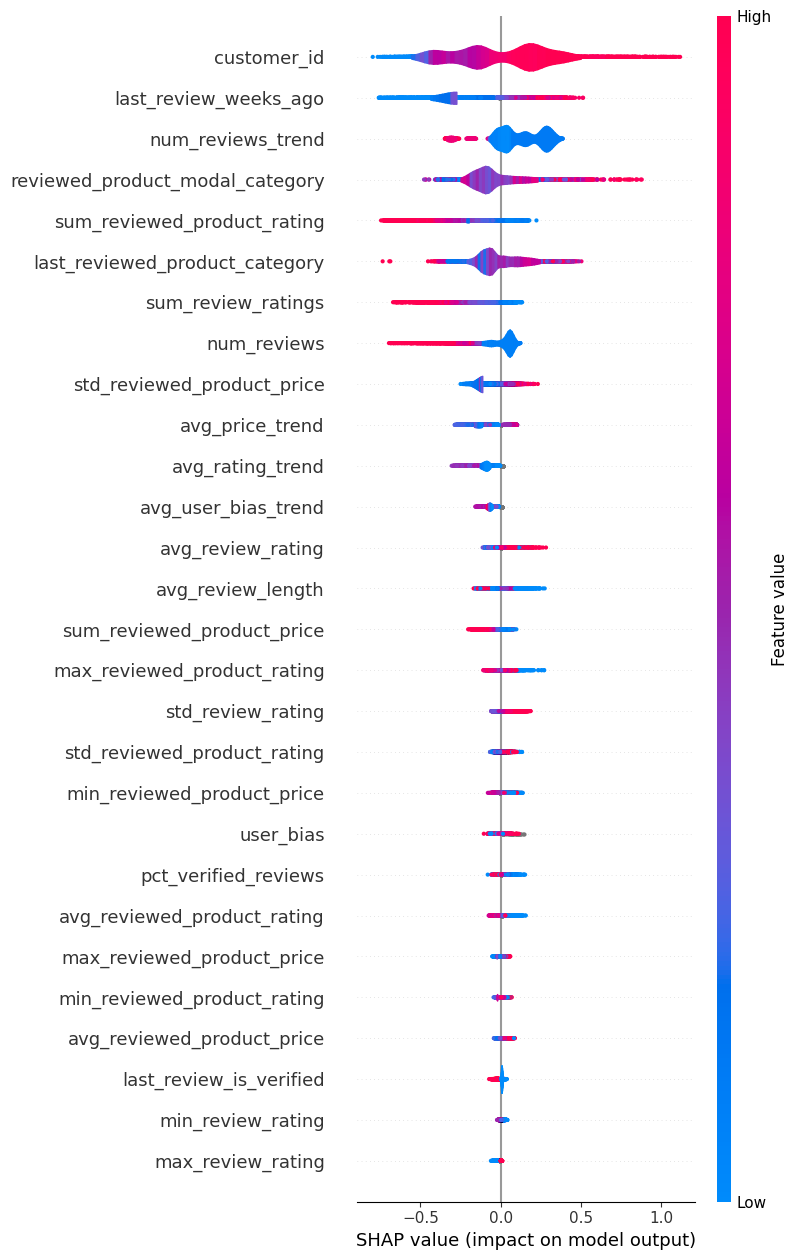

In [15]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

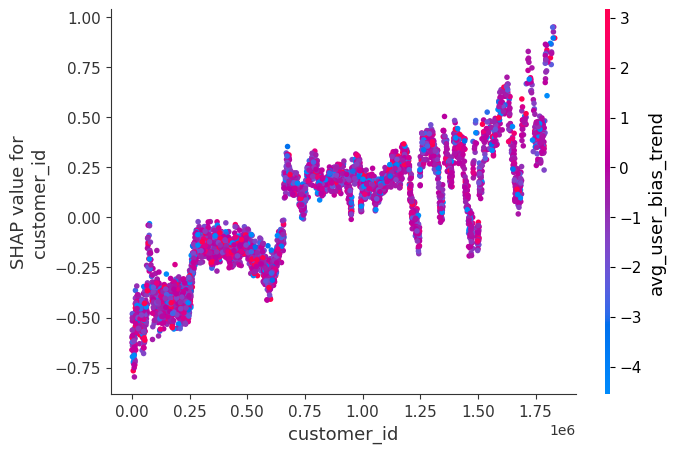

In [16]:
shap.dependence_plot('customer_id', shap_values, val_arr, feature_names=feat_names)

^-- Older customers churn less

In [17]:
conn.close()